In [4]:
import os
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
IMG_SIZE = 32
DATADIR = "archive (1)"
DATADIR_TEST = "test"
CATEGORIES = os.listdir(DATADIR)


In [3]:


# Set image size

# Add paths
DATADIR = "archive (1)"
DATADIR_TEST = "test"

# Initialize categories
CATEGORIES = os.listdir(DATADIR)

# Get test data
def create_test_data():
    test_images = []
    test_labels = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR_TEST, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_images.append(new_array)
                test_labels.append(class_num)
            except Exception as e:
                pass
    return np.array(test_images), np.array(test_labels)

# Get training data
def create_training_data():
    train_images = []
    train_labels = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train_images.append(new_array)
                train_labels.append(class_num)
            except Exception as e:
                pass
    return np.array(train_images), np.array(train_labels)


In [28]:

# Load the data
train_images, train_labels = create_training_data()
test_images, test_labels = create_test_data()

# Normalize the pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=len(CATEGORIES))
test_labels = to_categorical(test_labels, num_classes=len(CATEGORIES))

In [29]:
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)
np.save('test_images_testFolder.npy', test_images)
np.save('test_labels_testFolder.npy', test_labels)

In [2]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images_testFolder.npy')
test_labels = np.load('test_labels_testFolder.npy')

In [5]:


# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Load Pre-Trained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Feature Extraction: Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Train a New Classifier: Add a fully-connected layer and a logistic layer with the number of classes
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(CATEGORIES), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Optionally, freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the new classifier
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# Fine-Tuning (Optional): Unfreeze some layers of the base model and re-train
for layer in base_model.layers[-5:]:  # Unfreeze the last 4 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=14,
    batch_size=32
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

# Save the trained model
model.save('custom_vgg16_model.h5')


Epoch 1/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.5706 - loss: 1.0169 - val_accuracy: 0.6650 - val_loss: 0.8230
Epoch 2/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 79s 80ms/step - accuracy: 0.7125 - loss: 0.7385 - val_accuracy: 0.7274 - val_loss: 0.6993
Epoch 3/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.7555 - loss: 0.6269 - val_accuracy: 0.7527 - val_loss: 0.6572
Epoch 4/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 78s 79ms/step - accuracy: 0.7974 - loss: 0.5326 - val_accuracy: 0.7706 - val_loss: 0.6240
Epoch 5/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.8267 - loss: 0.4596 - val_accuracy: 0.7785 - val_loss: 0.6081
Epoch 6/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 80s 81ms/step - accuracy: 0.8534 - loss: 0.3959 - val_accuracy: 0.7970 - val_loss: 0.5676
Epoch 7/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - accuracy: 0.8793 - loss: 0.3353 - val_accuracy: 0.8049 - val_loss: 0.5694
Epoch 8/20
987/987 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.8961 - loss: 0.2895 - 

Test accuracy: 0.7222222089767456


In [31]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8333 - loss: 1.8535
Test accuracy: 0.8333333134651184


In [23]:
len(test_images)

18

In [32]:
DATADIR_TEST = "new test"



# Get test data
def create_test_data():
    test_images = []
    test_labels = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR_TEST, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_images.append(new_array)
                test_labels.append(class_num)
            except Exception as e:
                pass
    return np.array(test_images), np.array(test_labels)


new_test_images, new_test_labels = create_test_data()

In [33]:
acc = model.predict(new_test_images).argmax(axis=1) == new_test_labels

print(f"Accuracy: {acc.mean() * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Accuracy: 75.47%


In [34]:
model.predict(new_test_images).argmax(axis=1) == new_test_labels

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([ True,  True,  True, False, False, False, False, False,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True, False, False,
        True,  True, False, False, False, False, False,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,

In [25]:
new_test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


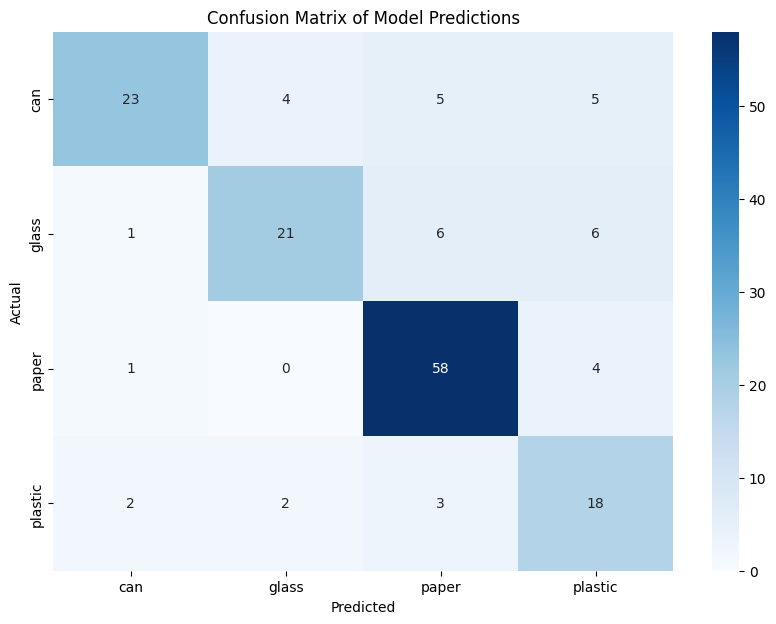

              precision    recall  f1-score   support

         can       0.85      0.62      0.72        37
       glass       0.78      0.62      0.69        34
       paper       0.81      0.92      0.86        63
     plastic       0.55      0.72      0.62        25

    accuracy                           0.75       159
   macro avg       0.75      0.72      0.72       159
weighted avg       0.77      0.75      0.75       159



In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming `model` is your trained model and `X_test`, `y_test` are your test data and labels
# Make predictions
y_pred = model.predict(new_test_images).argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(new_test_labels, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Model Predictions')
plt.show()

# Print classification report for additional insights
print(classification_report(new_test_labels, y_pred, target_names=CATEGORIES))

In [26]:
len(new_test_images)

117

In [26]:
DATADIR_TEST = "real_test"



# Get test data
def create_test_data():
    test_images = []
    test_labels = []
    for category in ['can','paper', 'plastic']:
        path = os.path.join(DATADIR_TEST, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_images.append(new_array)
                test_labels.append(class_num)
            except Exception as e:
                pass
    return np.array(test_images)/255.0, np.array(test_labels)


real_test_images, real_test_labels = create_test_data()

In [20]:
model.predict(real_test_images).argmax(axis=1) == real_test_labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


array([ True, False, False, False,  True,  True,  True, False, False,
       False])

# load model

In [21]:
from tensorflow.keras.models import load_model
real_test_images, real_test_labels = create_test_data()
# Load the model
model = load_model('custom_vgg16_model.h5')

model.predict(real_test_images).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


array([0, 3, 2, 2, 2, 2, 2, 3, 2, 2], dtype=int64)

In [11]:
real_test_images = list(real_test_images)

In [27]:
import numpy as np
from tensorflow.keras.models import load_model

# Load test data
real_test_images, real_test_labels = create_test_data()
# Load the pre-trained model
model = load_model('custom_vgg16_model.h5')

# Make predictions on the test images
predictions = model.predict(real_test_images)
confidence_percentages = np.max(predictions, axis=1)

# Print the predicted class and confidence percentage for each image
for i, confidence in enumerate(confidence_percentages):
    predicted_class = np.argmax(predictions[i])
    print(f"Image {i+1}: Predicted Class = {predicted_class}, Confidence = {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Image 1: Predicted Class = 0, Confidence = 0.92%
Image 2: Predicted Class = 0, Confidence = 0.98%
Image 3: Predicted Class = 2, Confidence = 0.62%
Image 4: Predicted Class = 0, Confidence = 0.94%
Image 5: Predicted Class = 2, Confidence = 1.00%
Image 6: Predicted Class = 2, Confidence = 1.00%
Image 7: Predicted Class = 2, Confidence = 1.00%
Image 8: Predicted Class = 2, Confidence = 0.96%
Image 9: Predicted Class = 1, Confidence = 0.83%
Image 10: Predicted Class = 1, Confidence = 0.62%


In [24]:
model.predict(real_test_images).argmax(axis=1) == real_test_labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([ True,  True, False,  True,  True,  True,  True,  True, False,
       False])

In [2]:
model.hy

<Functional name=functional_7, built=True>

In [12]:
weights = model.layers[2].get_weights()
weights

[array([[[[ 1.66219279e-01,  1.42701820e-01, -4.02113283e-03, ...,
            6.18828237e-02, -1.74057148e-02, -3.00644431e-02],
          [ 9.46945231e-03,  3.87477316e-03,  5.08365929e-02, ...,
           -2.77981739e-02,  1.71373668e-03,  6.82722731e-03],
          [ 6.32681847e-02,  2.12877709e-02, -1.63465310e-02, ...,
            8.80054955e-04,  6.68104272e-03, -1.41139806e-03],
          ...,
          [ 3.47490981e-03,  8.47019628e-02, -4.07223180e-02, ...,
           -1.13523193e-02, -7.48998486e-03,  3.19077494e-03],
          [ 5.97234145e-02,  4.97663505e-02, -3.23118735e-03, ...,
            1.43114366e-02,  3.03175431e-02, -4.23925705e-02],
          [ 1.33459672e-01,  4.95484173e-02, -1.78808011e-02, ...,
            2.25385167e-02,  3.02020740e-02, -2.17075031e-02]],
 
         [[ 2.12007999e-01,  2.10127644e-02, -1.47626130e-02, ...,
            2.29580477e-02,  1.23102348e-02, -3.08422819e-02],
          [-2.62175221e-03,  7.42094172e-03,  6.74030930e-02, ...,
     

In [8]:
weights = model.get_weights()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,244,102 (58.15 MB)

 Trainable params: 7,608,836 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

In [13]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('custom_vgg16_model.h5')

# Re-save the model in the current TensorFlow version
model.save('custom_vgg16_model_resaved.h5')

# Reload the model
model_resaved = tf.keras.models.load_model('custom_vgg16_model_resaved.h5')

# Convert the reloaded model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_resaved)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('custom_vgg16_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite!")


AttributeError: 'Functional' object has no attribute '_get_save_spec'